In [1]:
import logging

logging.basicConfig(
    level="INFO", format="%(asctime)s %(message)s", datefmt="%d-%b-%y %H:%M:%S"
)


In [2]:
from scripts.run_decoding import get_session_info

session_info = get_session_info()
session_info

28-Sep-23 14:47:40 Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
28-Sep-23 14:47:40 Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
28-Sep-23 14:47:40 NumExpr defaulting to 8 threads.
/home/edeno/miniconda3/envs/tk_decoding/lib/python3.10/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Empty DataFrame
Columns: []
Index: [(IM-1594, 07252023), (IM-1478, 07242022), (IM-1478, 07252022), (IM-1478, 07192022), (IM-1478, 07172022), (IM-1478, 07262022), (IM-1478, 07202022), (IM-1478, 07272022)]

In [3]:
from src.load_data import load_data
import os
from src.parameters import RAW_DATA_DIR, SAMPLING_FREQUENCY

animal, date = session_info.index[2]

raw_position_file_name = os.path.join(
    RAW_DATA_DIR, animal, date, f"{animal}_{date}_position.csv"
)
raw_spike_file_name = os.path.join(
    RAW_DATA_DIR, animal, date, f"{animal}_{date}_spikesWithPosition.csv"
)

(position_info, spikes, multiunit_firing_rate, multiunit_HSE_times,) = load_data(
    position_file_name=raw_position_file_name,
    spike_file_name=raw_spike_file_name,
)

start_ind = int(20.0 * SAMPLING_FREQUENCY)
position_info = position_info.iloc[start_ind:]
spikes = spikes.iloc[start_ind:]
multiunit_firing_rate = multiunit_firing_rate.iloc[start_ind:]
position_info


,Unnamed: 0,x,y,green_z_scored,head_direction,speed,velocity_x,velocity_y
time,,,,,,,,
21.612,5403,70.541401,25.573248,-0.2356,0.153186,7.990514e+00,7.896944e+00,1.219255
21.616,5404,70.509554,25.573248,-0.2563,0.174757,7.343604e+00,7.231752e+00,1.276827
21.620,5405,70.509554,25.573248,-0.2798,0.202695,6.716194e+00,6.578698e+00,1.352037
21.624,5406,70.509554,25.573248,-0.3044,0.238706,6.111849e+00,5.938547e+00,1.445116
21.628,5407,70.509554,25.573248,-0.3260,0.284994,5.535297e+00,5.312021e+00,1.556259
...,...,...,...,...,...,...,...,...
5204.772,1301193,33.299363,35.222930,-0.4536,0.000000,1.525847e-15,1.525847e-15,0.000000
5204.776,1301194,33.299363,35.222930,-0.5040,0.000000,1.522630e-15,1.522630e-15,0.000000
5204.780,1301195,33.299363,35.222930,-0.5635,0.000000,1.516939e-15,1.516939e-15,0.000000


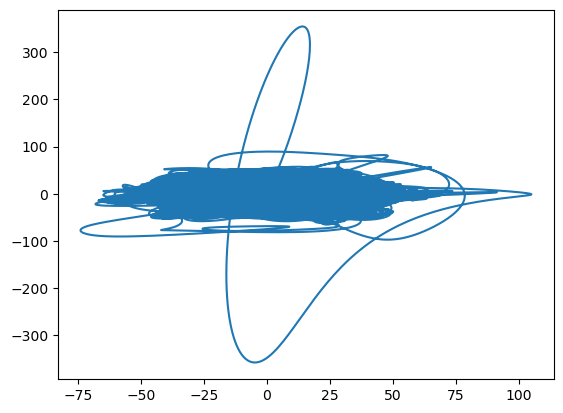

In [4]:
import matplotlib.pyplot as plt

plt.plot(position_info["velocity_x"], position_info["velocity_y"])

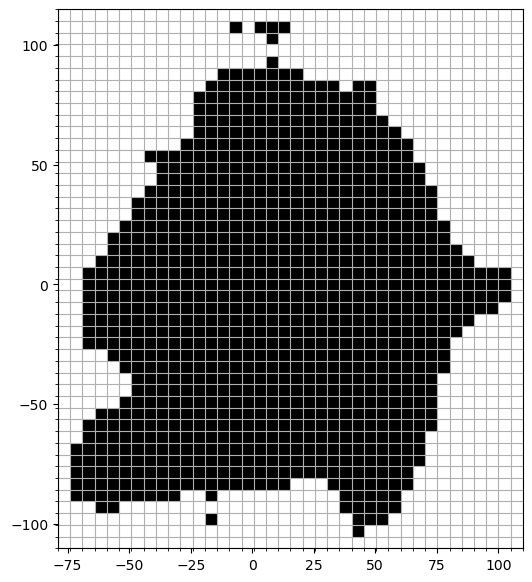

In [5]:
from replay_trajectory_classification import Environment
import numpy as np

velocity = position_info[["velocity_x", "velocity_y"]].to_numpy()
velocity[np.abs(velocity) > 110] = 110

velocity_env = Environment(
    place_bin_size=5.0, fill_holes=True, bin_count_threshold=0, dilate=False
).fit_place_grid(position=velocity)

velocity_env.plot_grid()

In [6]:
from replay_trajectory_classification import (
    Environment,
    RandomWalk,
    SortedSpikesClassifier,
    Uniform,
)

# Set up classifier
state_names = ["continuous", "fragmented"]
continuous_transition_types = [
    [RandomWalk(movement_var=24.0), Uniform()],
    [Uniform(), Uniform()],
]

velocity_classifier = SortedSpikesClassifier(
    environments=velocity_env,
    continuous_transition_types=continuous_transition_types,
    sorted_spikes_algorithm="spiking_likelihood_kde_gpu",
    sorted_spikes_algorithm_params={
        "position_std": 6.0,
        "use_diffusion": False,
        "block_size": int(2**12),
    },
)

In [7]:
import xarray as xr

# Decode
n_time = len(spikes)
# n_segments = n_time // (60 * 60 * SAMPLING_FREQUENCY)  # 1 hour segments
n_segments = 2
velocity_results = []

# Fit the place fields
print("Fitting place fields...")
velocity_classifier.fit(
    position=velocity,
    spikes=spikes,
)

for ind in range(n_segments):
    print(f"Predicting segment {ind}...")
    time_slice = slice(ind * n_time // n_segments, (ind + 1) * n_time // n_segments)
    velocity_results.append(
        velocity_classifier.predict(
            spikes.iloc[time_slice],
            time=spikes.iloc[time_slice].index.to_numpy(),
            state_names=state_names,
            use_gpu=True,
        )
    )
print("Concatenating decoding...")
velocity_results = xr.concat(velocity_results, dim="time").drop(
    ["likelihood", "causal_posterior"]
)


28-Sep-23 14:49:14 Fitting initial conditions...
28-Sep-23 14:49:14 Fitting continuous state transition...


Fitting place fields...


/home/edeno/miniconda3/envs/tk_decoding/lib/python3.10/site-packages/replay_trajectory_classification/continuous_state_transitions.py:23: RuntimeWarning: invalid value encountered in divide
  x /= x.sum(axis=1, keepdims=True)
28-Sep-23 14:49:14 Fitting discrete state transition
28-Sep-23 14:49:14 Fitting place fields...


  0%|          | 0/145 [00:00<?, ?it/s]

/home/edeno/miniconda3/envs/tk_decoding/lib/python3.10/site-packages/replay_trajectory_classification/likelihoods/spiking_likelihood_kde_gpu.py:115: RuntimeWarning: divide by zero encountered in log
  np.log(mean_rate) + np.log(marginal_density) - np.log(occupancy)
/home/edeno/miniconda3/envs/tk_decoding/lib/python3.10/site-packages/replay_trajectory_classification/likelihoods/spiking_likelihood_kde_gpu.py:115: RuntimeWarning: invalid value encountered in subtract
  np.log(mean_rate) + np.log(marginal_density) - np.log(occupancy)
28-Sep-23 14:50:11 Estimating likelihood...


Predicting segment 0...


  0%|          | 0/145 [00:00<?, ?it/s]

/home/edeno/miniconda3/envs/tk_decoding/lib/python3.10/site-packages/replay_trajectory_classification/likelihoods/spiking_likelihood_kde_gpu.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(is_track_interior, dtype=np.float)
28-Sep-23 14:51:06 Estimating causal posterior...


../../thread/thread_load.cuh(36): warning: cuda.h: [jitify] File not found
../../thread/thread_store.cuh(36): warning: cuda.h: [jitify] File not found


28-Sep-23 14:55:08 Estimating acausal posterior...
28-Sep-23 15:04:09 Estimating likelihood...


Predicting segment 1...


  0%|          | 0/145 [00:00<?, ?it/s]

/home/edeno/miniconda3/envs/tk_decoding/lib/python3.10/site-packages/replay_trajectory_classification/likelihoods/spiking_likelihood_kde_gpu.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(is_track_interior, dtype=np.float)
28-Sep-23 15:04:59 Estimating causal posterior...
28-Sep-23 15:08:51 Estimating acausal posterior...


Concatenating decoding...


In [8]:
# Set up classifier
state_names = ["continuous", "fragmented"]
position_environment = Environment(place_bin_size=2.0)
continuous_transition_types = [
    [RandomWalk(movement_var=12.0), Uniform()],
    [Uniform(), Uniform()],
]

position_classifier = SortedSpikesClassifier(
    environments=position_environment,
    continuous_transition_types=continuous_transition_types,
    sorted_spikes_algorithm="spiking_likelihood_kde_gpu",
    sorted_spikes_algorithm_params={
        "position_std": 6.0,
        "use_diffusion": False,
        "block_size": int(2**12),
    },
)

In [9]:
# Decode
n_time = len(spikes)
# n_segments = n_time // (60 * 60 * SAMPLING_FREQUENCY)  # 1 hour segments
n_segments = 2
position_results = []

# Fit the place fields
print("Fitting place fields...")
position_classifier.fit(
    position=position_info[["x", "y"]],
    spikes=spikes,
)

for ind in range(n_segments):
    print(f"Predicting segment {ind}...")
    time_slice = slice(ind * n_time // n_segments, (ind + 1) * n_time // n_segments)
    position_results.append(
        position_classifier.predict(
            spikes.iloc[time_slice],
            time=spikes.iloc[time_slice].index.to_numpy(),
            state_names=state_names,
            use_gpu=True,
        )
    )
print("Concatenating decoding...")
position_results = xr.concat(position_results, dim="time").drop(
    ["likelihood", "causal_posterior"]
)


Fitting place fields...


28-Sep-23 15:18:10 Fitting initial conditions...
28-Sep-23 15:18:10 Fitting continuous state transition...
/home/edeno/miniconda3/envs/tk_decoding/lib/python3.10/site-packages/replay_trajectory_classification/continuous_state_transitions.py:23: RuntimeWarning: invalid value encountered in divide
  x /= x.sum(axis=1, keepdims=True)
28-Sep-23 15:18:15 Fitting discrete state transition
28-Sep-23 15:18:15 Fitting place fields...


  0%|          | 0/145 [00:00<?, ?it/s]

/home/edeno/miniconda3/envs/tk_decoding/lib/python3.10/site-packages/replay_trajectory_classification/likelihoods/spiking_likelihood_kde_gpu.py:115: RuntimeWarning: divide by zero encountered in log
  np.log(mean_rate) + np.log(marginal_density) - np.log(occupancy)
/home/edeno/miniconda3/envs/tk_decoding/lib/python3.10/site-packages/replay_trajectory_classification/likelihoods/spiking_likelihood_kde_gpu.py:115: RuntimeWarning: invalid value encountered in subtract
  np.log(mean_rate) + np.log(marginal_density) - np.log(occupancy)
28-Sep-23 15:19:59 Estimating likelihood...


Predicting segment 0...


  0%|          | 0/145 [00:00<?, ?it/s]

/home/edeno/miniconda3/envs/tk_decoding/lib/python3.10/site-packages/replay_trajectory_classification/likelihoods/spiking_likelihood_kde_gpu.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(is_track_interior, dtype=np.float)
28-Sep-23 15:23:48 Estimating causal posterior...
28-Sep-23 15:28:33 Estimating acausal posterior...
28-Sep-23 15:46:51 Estimating likelihood...


Predicting segment 1...


  0%|          | 0/145 [00:00<?, ?it/s]

/home/edeno/miniconda3/envs/tk_decoding/lib/python3.10/site-packages/replay_trajectory_classification/likelihoods/spiking_likelihood_kde_gpu.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(is_track_interior, dtype=np.float)
28-Sep-23 15:52:34 Estimating causal posterior...
28-Sep-23 15:57:57 Estimating acausal posterior...


Concatenating decoding...


In [10]:
velocity_results.to_netcdf("velocity_results.nc")

In [11]:
position_results.to_netcdf("position_results.nc")

In [35]:
import sortingview.views as vv
from trajectory_analysis_tools import (
    maximum_a_posteriori_estimate,
    make_2D_track_graph_from_environment,
    get_ahead_behind_distance2D,
)

# from src.plot_data import create_2D_decode_view
from src.plot_data import (
    vvf,
    get_ul_corners,
    create_static_track_animation,
    create_track_animation_object,
    process_decoded_data,
)


def create_2D_decode_view(
    position_time: np.ndarray,
    position: np.ndarray,
    interior_place_bin_centers: np.ndarray,
    place_bin_size: np.ndarray,
    posterior: xr.DataArray,
    head_dir: np.ndarray = None,
) -> vvf.TrackPositionAnimationV1:
    """Creates a 2D decoding movie view

    Parameters
    ----------
    position_time : np.ndarray, shape (n_time,)
    position : np.ndarray, shape (n_time, 2)
    interior_place_bin_centers: np.ndarray, shape (n_track_bins, 2)
    place_bin_size : np.ndarray, shape (2, 1)
    posterior : xr.DataArray, shape (n_time, n_position_bins)
    head_dir : np.ndarray, optional

    Returns
    -------
    view : vvf.TrackPositionAnimationV1

    """
    assert (
        position_time.shape[0] == position.shape[0]
    ), "position_time and position must have the same length"
    assert (
        posterior.shape[0] == position.shape[0]
    ), "posterior and position must have the same length"

    position_time = np.squeeze(np.asarray(position_time)).copy()
    position = np.asarray(position)
    if head_dir is not None:
        head_dir = np.squeeze(np.asarray(head_dir))

    track_bin_width, track_bin_height = place_bin_size
    # NOTE: We expect caller to have converted from fortran ordering already
    # i.e. somewhere upstream, centers = env.place_bin_centers_[env.is_track_interior_.ravel(order="F")]
    upper_left_points = get_ul_corners(
        track_bin_width, track_bin_height, interior_place_bin_centers
    )

    data = create_static_track_animation(
        ul_corners=upper_left_points,
        track_rect_height=track_bin_height,
        track_rect_width=track_bin_width,
        timestamps=position_time,
        positions=position.T,
        head_dir=head_dir,
        compute_real_time_rate=True,
    )
    data["decodedData"] = process_decoded_data(posterior)

    return create_track_animation_object(static_track_animation=data)


def create_interactive_2D_decoding_figurl(
    position_info,
    position_results,
    velocity_results,
    position_env,
    velocity_env,
    position_name=["x", "y"],
    velocity_name=["velocity_x", "velocity_y"],
    head_direction_name="head_direction",
    posterior_type="acausal_posterior",
    view_height=800,
):
    position_posterior = position_results[posterior_type].sum("state")
    position_decode_view = create_2D_decode_view(
        position_time=position_info.index,
        position=position_info[position_name],
        interior_place_bin_centers=position_env.place_bin_centers_[
            position_env.is_track_interior_.ravel(order="F")
        ],
        place_bin_size=[np.median(np.diff(e)) for e in position_env.edges_],
        posterior=position_posterior,
        head_dir=position_info[head_direction_name],
    )
    # most_probable_decoded_position = maximum_a_posteriori_estimate(position_posterior)
    # track_graph = make_2D_track_graph_from_environment(position_env)
    # ahead_behind_distance = get_ahead_behind_distance2D(
    #     head_position=position_info[["x", "y"]].to_numpy(),
    #     head_direction=position_info["head_direction"].to_numpy(),
    #     map_position=np.asarray(most_probable_decoded_position),
    #     track_graph=track_graph,
    # )

    velocity_posterior = velocity_results[posterior_type].sum("state")
    velocity_decode_view = create_2D_decode_view(
        position_time=position_info.index,
        position=position_info[velocity_name],
        interior_place_bin_centers=velocity_env.place_bin_centers_[
            velocity_env.is_track_interior_.ravel(order="F")
        ],
        place_bin_size=[np.median(np.diff(e)) for e in velocity_env.edges_],
        posterior=velocity_posterior,
        head_dir=None,
    )
    most_probable_decoded_velocity = maximum_a_posteriori_estimate(velocity_posterior)
    decoded_velocity_complex = (
        most_probable_decoded_velocity[:, 0] + 1j * most_probable_decoded_velocity[:, 1]
    )
    most_probable_decoded_head_direction = np.angle(decoded_velocity_complex)
    most_probable_decoded_speed = np.abs(decoded_velocity_complex)

    speed_view = vv.TimeseriesGraph()
    speed_view.add_line_series(
        name="Speed [cm/s]",
        t=np.asarray(position_info.index),
        y=np.asarray(position_info["speed"], dtype=np.float32).squeeze(),
        color="black",
        width=1,
    )
    speed_view.add_line_series(
        name="Decoded Speed [cm/s]",
        t=np.asarray(position_info.index),
        y=np.asarray(most_probable_decoded_speed, dtype=np.float32).squeeze(),
        color="red",
        width=1,
    )

    head_dir_view = vv.TimeseriesGraph()
    head_dir_view.add_line_series(
        name="Head Dir. [rad]",
        t=np.asarray(position_info.index),
        y=np.asarray(position_info["head_direction"], dtype=np.float32).squeeze(),
        color="black",
        width=1,
    )
    head_dir_view.add_line_series(
        name="Decoded Head Dir.[rad]",
        t=np.asarray(position_info.index),
        y=np.asarray(most_probable_decoded_head_direction, dtype=np.float32).squeeze(),
        color="red",
        width=1,
    )

    # ahead_behind_view = vv.TimeseriesGraph().add_line_series(
    #     name="Dist. to Animal [cm]",
    #     t=np.asarray(position_results.time),
    #     y=np.asarray(ahead_behind_distance, dtype=np.float32).squeeze(),
    #     color="black",
    #     width=1,
    # )

    vertical_panel1_content = [
        vv.LayoutItem(position_decode_view, stretch=1, title="Pos. Decode"),
    ]

    vertical_panel2_content = [
        # vv.LayoutItem(ahead_behind_view, stretch=1, title="Ahead/Behind Dist."),
        vv.LayoutItem(speed_view, stretch=1, title="Speed"),
        vv.LayoutItem(head_dir_view, stretch=1, title="Head Dir."),
        vv.LayoutItem(velocity_decode_view, stretch=3, title="Vel. Decode"),
    ]

    view = vv.Box(
        direction="horizontal",
        show_titles=True,
        height=view_height,
        items=[
            vv.LayoutItem(
                vv.Box(
                    direction="vertical",
                    show_titles=True,
                    items=vertical_panel1_content,
                )
            ),
            vv.LayoutItem(
                vv.Box(
                    direction="vertical",
                    show_titles=True,
                    items=vertical_panel2_content,
                )
            ),
        ],
    )

    return view.url(label="")

In [36]:
create_interactive_2D_decoding_figurl(
    position_info,
    position_results,
    velocity_results,
    position_environment,
    velocity_env,
)


/home/edeno/miniconda3/envs/tk_decoding/lib/python3.10/site-packages/xarray/core/computation.py:760: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


Computing sha1 of /stelmo/nwb/.kachery-cloud/tmp_5fgI4N3E/file.dat
Computing sha1 of /stelmo/nwb/.kachery-cloud/tmp_kzJqh7hu/file.dat


'https://figurl.org/f?v=gs://figurl/spikesortingview-10&d=sha1://b38abb9e57af503d38ac5843f8fbfd98094577be&label=&zone=franklab.default'

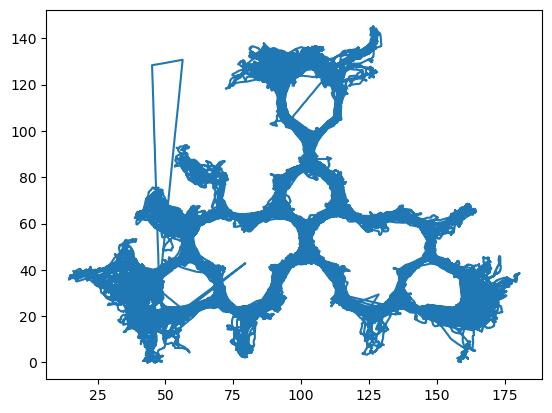

In [34]:
plt.plot(position_info["x"], position_info["y"])